In [1]:
import scipy.io
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.spatial import distance
from geopy.distance import geodesic
import geopy.point as point
from tools import *
from pylab import *

In [119]:
london_20 = 'london_square'
paris_20 = 'paris_square_20'
toulouse_20 = 'toulouse_square_20'

base_ld = f'./dataset/london_square_cell.mat'
base_pr = f'./dataset/{paris_20}_cell.mat'
base_tl = f'./dataset/{toulouse_20}_cell.mat'

In [120]:
meta_ld, cirs_ld, dist_ld, Y_all_ld, RX_all_ld = read_mat(base_ld, london_20)
meta_pr, cirs_pr, dist_pr, Y_all_pr, RX_all_pr = read_mat(base_pr, paris_20)
meta_toul, cirs_toul, dist_toul, Y_all_toul, RX_all_toul = read_mat(base_tl, toulouse_20)

In [121]:
base_pr_1 = f'./dataset/data_with_building/{paris_20}_cell.mat'
base_tl_1 = f'./dataset/data_with_building/{toulouse_20}_cell.mat'

_, cirs_pr_1, _, _, _  = read_mat(base_pr_1, paris_20)
_, cirs_toul_1, _, _, _ = read_mat(base_tl_1, toulouse_20)

In [122]:
geodesic(Y_all_ld[0], Y_all_ld[22]), geodesic(Y_all_toul[0], Y_all_toul[22])

(Distance(0.1176874793043784), Distance(0.11768753684321663))

# Preprocess

In [123]:
def distance_tr(TX, RX):
    """Calculate distance between every tx and rx"""
    new_dist = []
    for t in TX:
        new_dist.append(np.array([
            geodesic(t, r).m for r in RX
        ]))
    return np.array(new_dist)

In [124]:
new_dist_ld = distance_tr(Y_all_ld, RX_all_ld)
new_dist_toul = distance_tr(Y_all_toul, RX_all_toul)

In [125]:
def formatting(cirs_ld, max_len=10):
    T, S = cirs_ld.shape
    x_pre = []
    for j in range(T):
        cir_t = [] # channel impulse response for a transmitter
        for i in range(S):
            c_tmp = cirs_ld[j, i].copy()   
            m, n = c_tmp.shape
            if m < 2:
                # c_amp = np.zeros((1,max_len))
                c_amp = [0] * max_len
            else:
                if n > max_len:
                    c_amp = abs(c_tmp[1, 0:max_len])  
                else:
                    c_amp = abs(np.pad(c_tmp[1, :], (0, max_len-n),  constant_values=0))
                # c_amp = abs(c_tmp[1, :])    

            # cir_shaped = np.pad(c_amp, (0, 5 - n), constant_values=0)
            cir_t.extend(c_amp)

        x_pre.append(np.array(cir_t))

    X_amp = np.array(x_pre)
    return X_amp

In [126]:
X_ld = formatting(cirs_ld, max_len=10)
X_pr = formatting(cirs_pr, max_len=10)
X_tl = formatting(cirs_toul, max_len=10)

In [127]:
X_pr_1 = formatting(cirs_pr_1, max_len=10)
X_tl_1 = formatting(cirs_toul_1, max_len=10)

# Learning

In [128]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.pipeline import Pipeline
import seaborn as sns
import lightgbm as lgb
from scipy.optimize import minimize, Bounds
from sklearn.ensemble import AdaBoostRegressor as ABR

In [129]:
rf_grid = {
    'rf__max_depth': [100, 200, 500, 1000, 1500, 2000]
}

In [130]:
xgb_pipe = Pipeline([('scale', StandardScaler()), \
    ('xgb', MultiOutputRegressor(xgb.XGBRegressor(n_estimators=500, max_depth=2000, eta=0.1, subsample=1, colsample_bytree=1, reg_lambda=0)))])

lgb_pipe = Pipeline([('scale', StandardScaler()), \
    ('lgb', MultiOutputRegressor(lgb.LGBMRegressor(n_estimators=500, max_depth=2000, eta=0.1, subsample=1, colsample_bytree=1, reg_lambda=0)))])

rf_pipe = GridSearchCV(Pipeline([('scale', StandardScaler()), ('rf', RF(max_depth=2000))]), rf_grid)

# dt_pipe = Pipeline([('scale', StandardScaler()), ('dt', DT(max_depth=2000))])

ada_pipe = Pipeline([('scale', StandardScaler()), \
    ('ada', MultiOutputRegressor(ABR(n_estimators=100)))])

In [131]:
pipes = [xgb_pipe, lgb_pipe, rf_pipe, ada_pipe]
model_ls = ['XGB', 'LGBM', 'RF', 'Ada']

In [132]:
def optimize(RX, dist_pred):
    """find x through distance and rx coordinates"""

    def dist2coord(x, coords, dists):

        d = np.array([geodesic(x, coord).m for coord in coords])

        return np.linalg.norm([d-dists])**2

    x_pred = []

    bounds = Bounds([0, -90], [90, 90])

    for p in dist_pred:
        res = minimize(
        dist2coord,
        RX[0],
        args=(RX, p),
        method='L-BFGS-B',
        options={
            'ftol':1e-5,         # Tolerance
            'maxiter': 1e+7      # Maximum iterations
        },
        bounds=bounds
    )   

        x_pred.append(res.x)

    return np.array(x_pred)

def cdf_plot(data, ax=plt, label=None):
    n = len(data)
    x = np.arange(n) / (n-1)
    y = np.sort(data)

    ax.plot(y, x, '--',label=label, linewidth=2)
        

In [133]:
x_train, x_test, dist_train, dist_test, tx_train, tx_test = train_test_split(X_ld, dist_ld, Y_all_ld, train_size=.75)

In [134]:
model_1 = lgb_pipe

model_1.fit(X_ld, dist_ld)

pr_d_p = model_1.predict(X_pr)
tl_d_p = model_1.predict(X_tl)

[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1


In [92]:
pr_pred = optimize(RX_all_pr, pr_d_p)
toul_pred = optimize(RX_all_toul, tl_d_p)

In [93]:
pr_error = dist_from_geo(pr_pred, Y_all_pr)
toul_error = dist_from_geo(toul_pred, Y_all_toul)

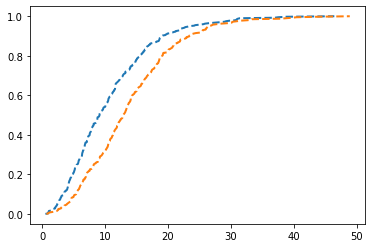

In [94]:
cdf_plot(pr_error)
cdf_plot(toul_error)


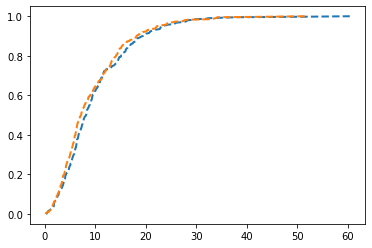

In [38]:
cdf_plot(pr_error)
cdf_plot(toul_error)


In [91]:
model_test = lgb_pipe

model_test.fit(x_train, dist_train)

ld_dist_pred = model_test.predict(x_test)
pr_dist_pred = model_test.predict(X_pr)
toul_dist_pred = model_test.predict(X_tl)

[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1


In [92]:
ld_loc_pred = optimize(RX_all_ld, ld_dist_pred)
pr_loc_pred = optimize(RX_all_pr, pr_dist_pred)
toul_loc_pred = optimize(RX_all_toul, toul_dist_pred)

In [93]:
ld_error = dist_from_geo(ld_loc_pred, tx_test)
pr_error = dist_from_geo(pr_loc_pred, Y_all_pr)
toul_error = dist_from_geo(toul_loc_pred, Y_all_toul)

Text(0.5, 0, 'Error (m)')

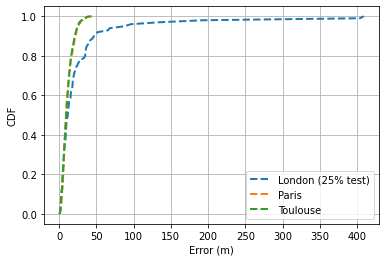

In [94]:
cdf_plot(ld_error, label='London (25% test)')
cdf_plot(pr_error, label='Paris')
cdf_plot(toul_error, label='Toulouse')
plt.legend(loc='best')
plt.grid()
# plt.title('Transfer learning comparison')
plt.ylabel('CDF')
plt.xlabel('Error (m)')
# plt.savefig('../imgs/tl_city_comp.pdf')

In [22]:
ld_toa = optimize(RX_all_ld, toa_ld)
pr_toa = optimize(RX_all_pr, toa_pr)
tl_toa = optimize(RX_all_toul, toa_tl)

ld_toa_e = dist_from_geo(ld_toa, Y_all_ld)
pr_toa_e = dist_from_geo(pr_toa, Y_all_pr)
tl_toa_e = dist_from_geo(tl_toa, Y_all_toul)

NameError: name 'toa_ld' is not defined

# Paris TOA multilateration

In [128]:
pr_toa = optimize(RX_all_pr, toa_pr)
pr_toa_e = dist_from_geo(pr_toa, Y_all_pr)

Text(0.5, 0, 'Error (m)')

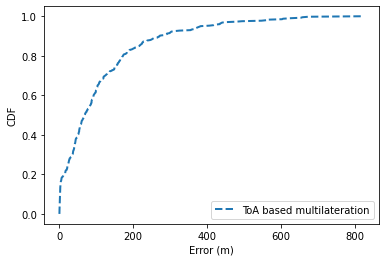

In [43]:
cdf_plot(ld_toa_e)
plt.legend(['ToA based multilateration'])
plt.ylabel('CDF')
plt.xlabel('Error (m)')

Text(0.5, 0, 'Error (m)')

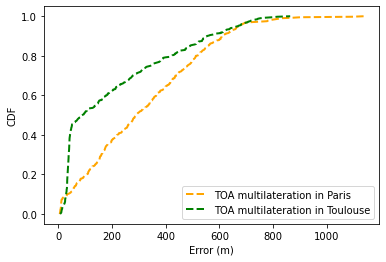

In [47]:
# cdf_plot(ld_toa_e, label='London (25% test)')
# cdf_plot(ld_toa_e, label='TOA multilateration in London')
cdf_plot(pr_toa_e, label='TOA multilateration in Paris', c='orange')
cdf_plot(tl_toa_e, label='TOA multilateration in Toulouse', c='g')
# cdf_plot(tl_toa_e, label='Toulouse')
plt.legend(loc='best')
plt.ylabel('CDF')
plt.xlabel('Error (m)')
# plt.savefig('../imgs/toa.pdf')

Text(0.5, 0, 'Error (m)')

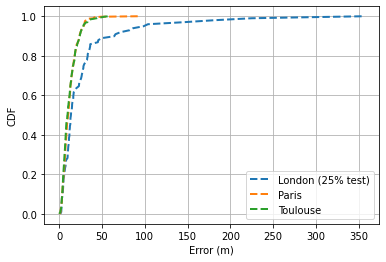

In [24]:
cdf_plot(ld_error, label='London (25% test)')
cdf_plot(pr_error, label='Paris')
cdf_plot(toul_error, label='Toulouse')
plt.legend(loc='best')
plt.grid()
# plt.title('Transfer learning comparison')
plt.ylabel('CDF')
plt.xlabel('Error (m)')
# plt.savefig('../imgs/tl_city_comp.pdf')

In [265]:

np.mean(pr_error), np.mean(toul_error), max(pr_error), max(toul_error)

(16.628312833434087, 21.924659273592724, 43.594912917482326, 48.19147838456041)

In [276]:
import scipy.stats
kde = scipy.stats.gaussian_kde(pr_error)
kde2 = scipy.stats.gaussian_kde(toul_error)


In [277]:
kde.integrate_box_1d(-1000, 20), kde2.integrate_box_1d(-1000, 20)

(0.6400229175375534, 0.4055892372364576)

Text(0.5, 0, 'Error (m)')

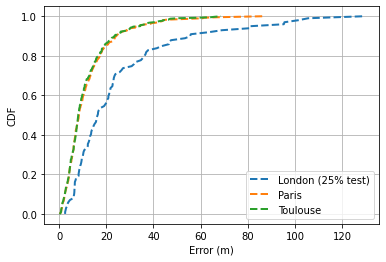

In [159]:
cdf_plot(ld_error, label='London (25% test)')
cdf_plot(pr_error, label='Paris')
cdf_plot(toul_error, label='Toulouse')
plt.legend(loc='best')
plt.grid()
# plt.title('Transfer learning comparison')
plt.ylabel('CDF')
plt.xlabel('Error (m)')
# plt.savefig('../imgs/tl_city_comp.pdf')

Text(0.5, 0, 'Error (m)')

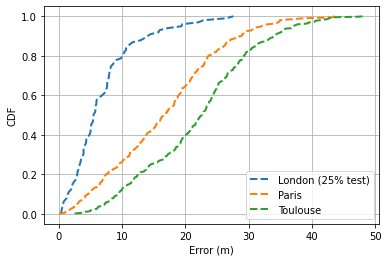

In [264]:
cdf_plot(ld_error, label='London (25% test)')
cdf_plot(pr_error, label='Paris')
cdf_plot(toul_error, label='Toulouse')
plt.legend(loc='best')
plt.grid()
# plt.title('Transfer learning comparison')
plt.ylabel('CDF')
plt.xlabel('Error (m)')
# plt.savefig('../imgs/tl_city_comp.pdf')

Text(0.5, 0, 'Error (m)')

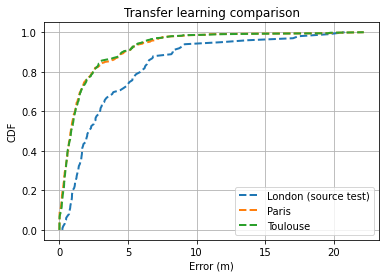

In [243]:
cdf_plot(ld_error, label='London (source test)')
cdf_plot(pr_error, label='Paris')
cdf_plot(toul_error, label='Toulouse')
plt.legend(loc='best')
plt.grid()
plt.title('Transfer learning comparison')
plt.ylabel('CDF')
plt.xlabel('Error (m)')

In [81]:
dist_error_ld_reg = []

for pipe in pipes:
    pipe.fit(x_train, dist_train)
    dist_pred_tmp = pipe.predict(x_test)
    loc_pred_tmp = optimize(RX_all_ld, dist_pred_tmp)

    dist_error_ld_reg.append(dist_from_geo(loc_pred_tmp, tx_test))

[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1


# Comparison with added target data

In [135]:
percentages = [0, .1, .2, .3, .5]

### target data with higher weights

In [136]:
dist_error_pr_p = []

for percent in percentages:
    if percent == 0:
        X_mixed = X_ld
        Y_mixed = dist_ld
        x_test_pr = X_pr
        tx_test_pr = Y_all_pr
        sample_weight = np.ones(len(X_mixed))

    else:
        x_train_pr, x_test_pr, dist_train_pr, dist_test_pr, tx_train_pr, tx_test_pr = \
            train_test_split(X_pr, dist_pr, Y_all_pr, train_size=percent)

        X_mixed = np.concatenate([X_ld, x_train_pr])
        Y_mixed = np.concatenate([dist_ld, dist_train_pr])

        sample_weight = np.ones(len(X_mixed))
        sample_weight[-len(x_train_pr):] *= 5

    lgb_pipe = Pipeline([('scale', StandardScaler()), \
    ('lgb', MultiOutputRegressor(lgb.LGBMRegressor(n_estimators=500, max_depth=2000, eta=0.1, subsample=1, colsample_bytree=1, reg_lambda=0)))])

    lgb_pipe.fit(X_mixed, Y_mixed, lgb__sample_weight=sample_weight)

    dist_pred_tmp = lgb_pipe.predict(x_test_pr)

    loc_pred_tmp = optimize(RX_all_pr, dist_pred_tmp)

    dist_error_pr_p.append(dist_from_geo(loc_pred_tmp, tx_test_pr))  

[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1


Text(0.5, 0, 'Error (m)')

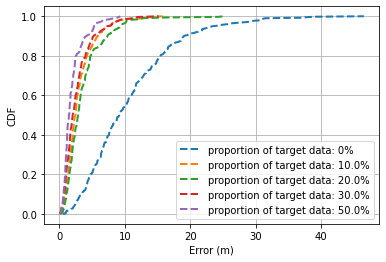

In [137]:
for d_e, p in zip(dist_error_pr_p, percentages):
    cdf_plot(d_e, label=f'proportion of target data: {p*100}%')

plt.legend(loc='best')
plt.grid()
# plt.title('Transfer learning with the support of target dataset')
plt.ylabel('CDF')
plt.xlabel('Error (m)')
# plt.savefig('../imgs/tl_pr_percent.pdf')

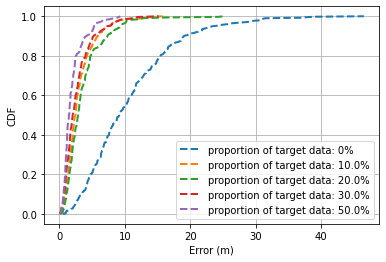

In [139]:
for d_e, p in zip(dist_error_pr_p, percentages):
    cdf_plot(d_e, label=f'proportion of target data: {p*100}%')

plt.legend(loc='best')
plt.grid()
# plt.title('Transfer learning with the support of target dataset')
plt.ylabel('CDF')
plt.xlabel('Error (m)')
plt.savefig('../imgs/tl_pr_percent.pdf')

### Training with  equal weights on target data

In [149]:
from copy import deepcopy

In [155]:
dist_error_pr_p = []
dist_e_pr_p_eq = []

for percent in percentages:
    if percent == 0:
        X_mixed = X_ld
        Y_mixed = dist_ld
        x_test_pr = X_pr
        tx_test_pr = Y_all_pr
        sample_weight = np.ones(len(X_mixed))

    else:
        x_train_pr, x_test_pr, dist_train_pr, dist_test_pr, tx_train_pr, tx_test_pr = \
            train_test_split(X_pr, dist_pr, Y_all_pr, train_size=percent)

        X_mixed = np.concatenate([X_ld, x_train_pr])
        Y_mixed = np.concatenate([dist_ld, dist_train_pr])

        sample_weight = np.ones(len(X_mixed))
        sample_weight[-len(x_train_pr):] *= 5

    lgb_pipe = Pipeline([('scale', StandardScaler()), \
    ('lgb', MultiOutputRegressor(lgb.LGBMRegressor(n_estimators=500, max_depth=2000, eta=0.1, subsample=1, colsample_bytree=1, reg_lambda=0)))])

    model = lgb_pipe
    model_eq = deepcopy(lgb_pipe)

    model.fit(X_mixed, Y_mixed, lgb__sample_weight=sample_weight)
    model_eq.fit(X_mixed, Y_mixed)



    dist_pred_tmp = model.predict(x_test_pr)
    dist_pred_2 = model_eq.predict(x_test_pr)

    loc_pred_tmp = optimize(RX_all_pr, dist_pred_tmp)
    loc_pred_2 = optimize(RX_all_pr, dist_pred_2)

    dist_error_pr_p.append(dist_from_geo(loc_pred_tmp, tx_test_pr))  
    dist_e_pr_p_eq.append(dist_from_geo(loc_pred_2, tx_test_pr))

[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1


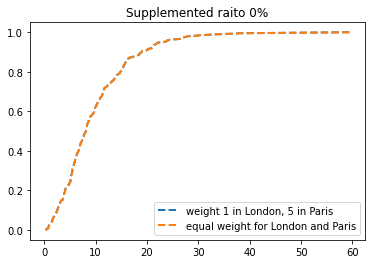

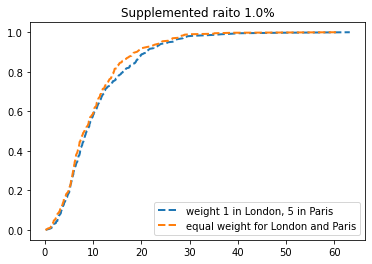

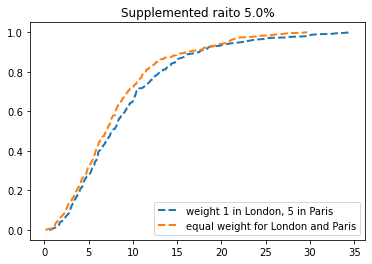

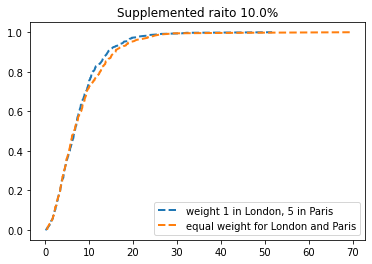

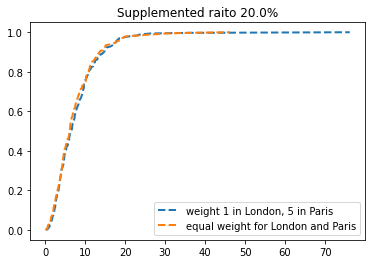

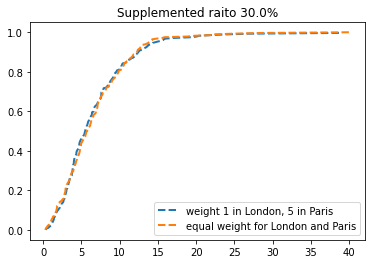

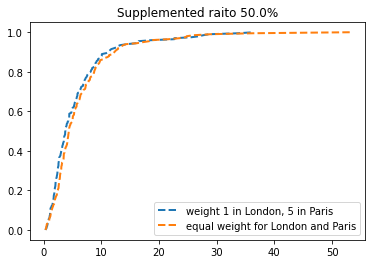

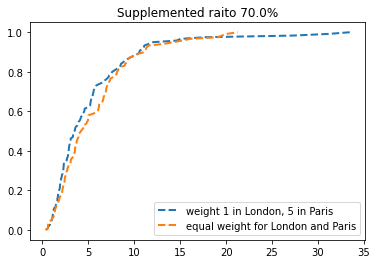

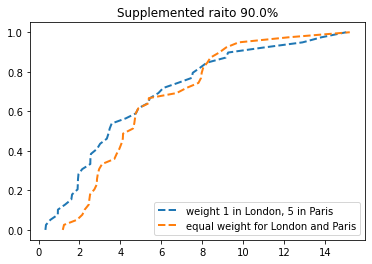

In [156]:
for d1, d2, p in zip(dist_error_pr_p, dist_e_pr_p_eq, percentages):
    plt.figure()
    cdf_plot(d1, label='weight 1 in London, 5 in Paris')
    cdf_plot(d2, label='equal weight for London and Paris')
    plt.title(f'Supplemented raito {p*100}%')
    plt.legend(loc='best')

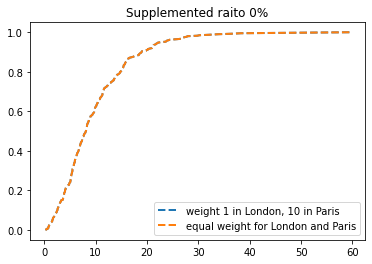

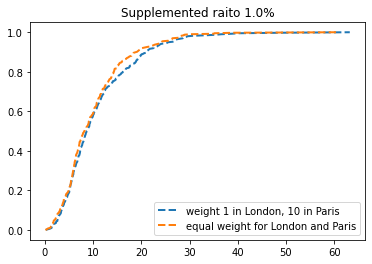

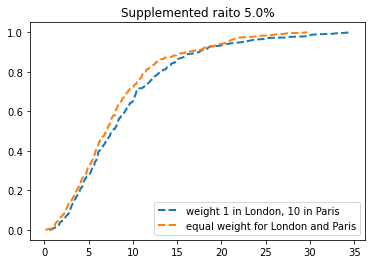

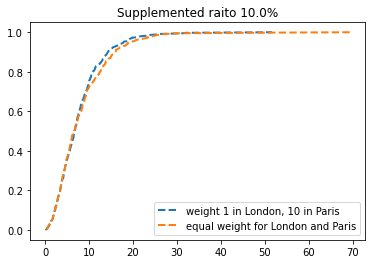

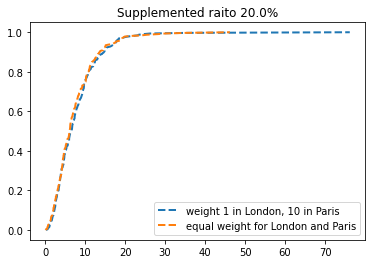

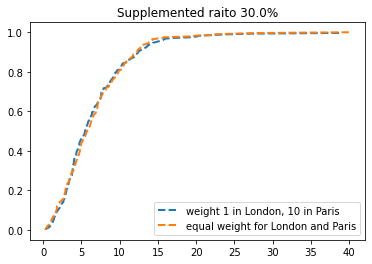

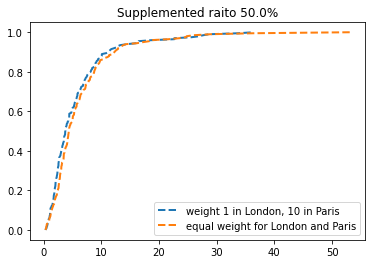

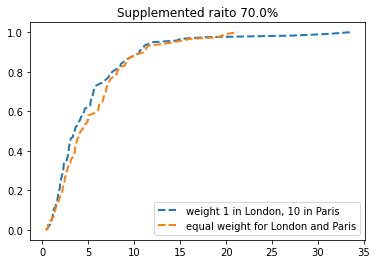

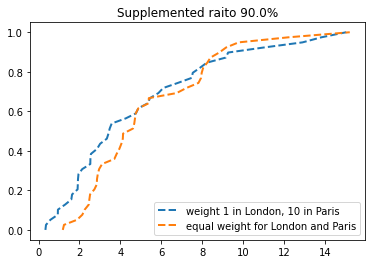

In [158]:
for d1, d2, p in zip(dist_error_pr_p, dist_e_pr_p_eq, percentages):
    plt.figure()
    cdf_plot(d1, label='weight 1 in London, 10 in Paris')
    cdf_plot(d2, label='equal weight for London and Paris')
    plt.title(f'Supplemented raito {p*100}%')
    plt.legend(loc='best')

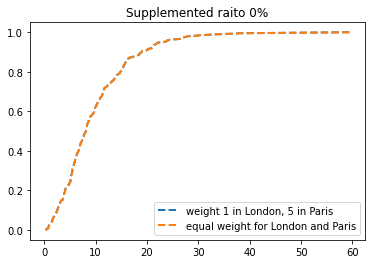

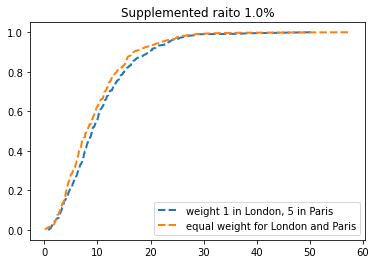

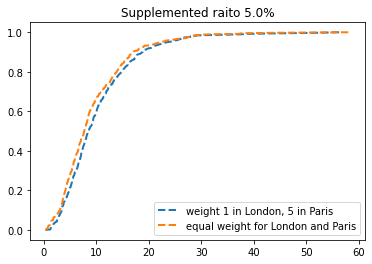

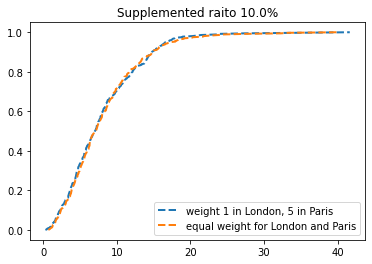

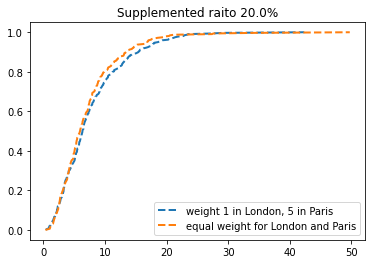

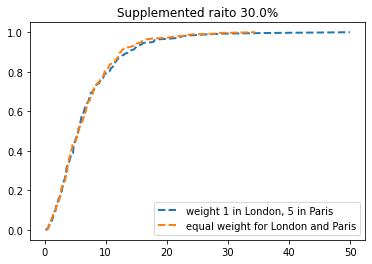

In [154]:
for d1, d2, p in zip(dist_error_pr_p, dist_e_pr_p_eq, percentages):
    plt.figure()
    cdf_plot(d1, label='weight 1 in London, 5 in Paris')
    cdf_plot(d2, label='equal weight for London and Paris')
    plt.title(f'Supplemented raito {p*100}%')
    plt.legend(loc='best')

In [ ]:
for d_e, p in zip(dist_error_pr_p, percentages):
    cdf_plot(d_e, label=f'proportion of target data: {p*100}%')

plt.legend(loc='best')
plt.grid()
# plt.title('Transfer learning with the support of target dataset')
plt.ylabel('CDF')
plt.xlabel('Error (m)')
# plt.savefig('../imgs/tl_pr_percent.pdf')

In [118]:
for d_e, p in zip(dist_error_pr_p, percentages):
    cdf_plot(d_e, label=f'proportion of target data: {p*100}%')

plt.legend(loc='best')
plt.grid()
# plt.title('Transfer learning with the support of target dataset')
plt.ylabel('CDF')
plt.xlabel('Error (m)')
# plt.savefig('../imgs/tl_pr_percent.pdf')

NameError: name 'dist_error_pr_p' is not defined

Text(0.5, 0, 'Error (m)')

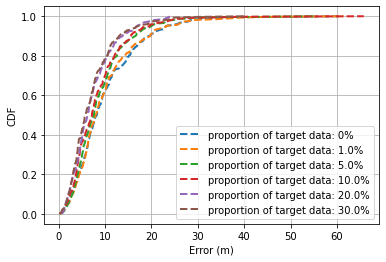

In [322]:
for d_e, p in zip(dist_error_pr_p, percentages):
    cdf_plot(d_e, label=f'proportion of target data: {p*100}%')

plt.legend(loc='best')
plt.grid()
# plt.title('Transfer learning with the support of target dataset')
plt.ylabel('CDF')
plt.xlabel('Error (m)')
# plt.savefig('../imgs/tl_pr_percent.pdf')

Text(0.5, 0, 'Error (m)')

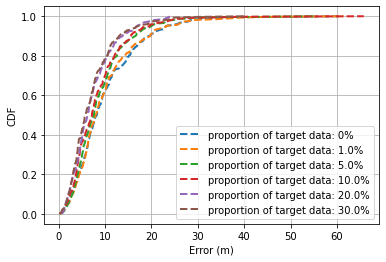

In [327]:
for d_e, p in zip(dist_error_pr_p, percentages):
    cdf_plot(d_e, label=f'proportion of target data: {p*100}%')

plt.legend(loc='best')
plt.grid()
# plt.title('Transfer learning with the support of target dataset')
plt.ylabel('CDF')
plt.xlabel('Error (m)')
# plt.savefig('../imgs/tl_pr_percent.pdf')

Text(0.5, 0, 'Error (m)')

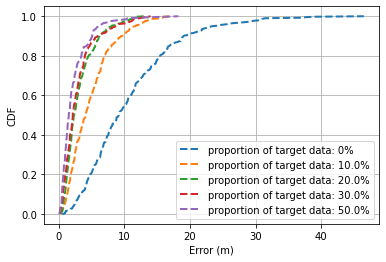

In [256]:
for d_e, p in zip(dist_error_pr_p, percentages):
    cdf_plot(d_e, label=f'proportion of target data: {p*100}%')

plt.legend(loc='best')
plt.grid()
# plt.title('Transfer learning with the support of target dataset')
plt.ylabel('CDF')
plt.xlabel('Error (m)')
# plt.savefig('../imgs/tl_pr_percent.pdf')

In [337]:
x_test_tl.shape, X_mixed.shape, X_ld.shape
percent
X_tl.shape

(400, 250)

In [128]:
dist_error_tl_p = []

for percent in percentages:
    if percent == 0:
        X_mixed = X_ld
        Y_mixed = dist_ld
        x_test_tl = X_tl
        tx_test_tl = Y_all_toul
    else:
        x_train_tl, x_test_tl, dist_train_tl, dist_test_tl, tx_train_tl, tx_test_tl = \
            train_test_split(X_tl, dist_toul, Y_all_toul, train_size=percent)

        X_mixed = np.concatenate([X_ld, x_train_tl])
        Y_mixed = np.concatenate([dist_ld, dist_train_tl])

    lgb_pipe = Pipeline([('scale', StandardScaler()), \
    ('lgb', MultiOutputRegressor(lgb.LGBMRegressor(n_estimators=500, max_depth=2000, eta=0.1, subsample=1, colsample_bytree=1, reg_lambda=0)))])
    model = lgb_pipe

    model.fit(X_mixed, Y_mixed)

    dist_pred_tmp = model.predict(x_test_tl)

    loc_pred_tmp = optimize(RX_all_toul, dist_pred_tmp)

    dist_error_tl_p.append(dist_from_geo(loc_pred_tmp, tx_test_tl))    

NameError: name 'percentages' is not defined

In [ ]:
for d_e, p in zip(dist_error_tl_p, percentages):
    cdf_plot(d_e, label=f'percentage of target data: {p*100}%')

plt.legend(loc='best')
plt.grid()
# plt.title('Transfer learning with the support of target dataset')
plt.ylabel('CDF')
plt.xlabel('Error (m)')
# plt.savefig('../imgs/tl_tout_percent.pdf')

In [127]:
for d_e, p in zip(dist_error_tl_p, percentages):
    cdf_plot(d_e, label=f'percentage of target data: {p*100}%')

plt.legend(loc='best')
plt.grid()
# plt.title('Transfer learning with the support of target dataset')
plt.ylabel('CDF')
plt.xlabel('Error (m)')
# plt.savefig('../imgs/tl_tout_percent.pdf')

NameError: name 'dist_error_tl_p' is not defined

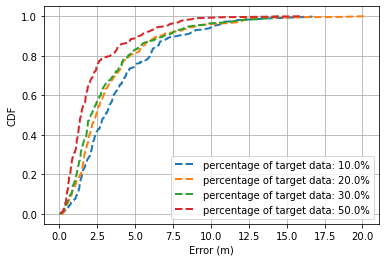

In [242]:
for d_e, p in zip(dist_error_tl_p, percentages):
    cdf_plot(d_e, label=f'percentage of target data: {p*100}%')

plt.legend(loc='best')
plt.grid()
# plt.title('Transfer learning with the support of target dataset')
plt.ylabel('CDF')
plt.xlabel('Error (m)')
plt.savefig('../imgs/tl_tout_percent.pdf')

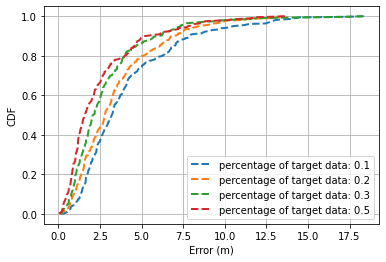

In [224]:
for d_e, p in zip(dist_error_tl_p, percentages):
    cdf_plot(d_e, label=f'percentage of target data: {p}')

plt.legend(loc='best')
plt.grid()
# plt.title('Transfer learning with the support of target dataset')
plt.ylabel('CDF')
plt.xlabel('Error (m)')
plt.savefig('../imgs/tl_tout_percent.pdf')

# Comparison on regressors

In [60]:
dist_error_pr_reg = []

for pipe in pipes:
    pipe.fit(X_ld, dist_ld)
    dist_pred_tmp = pipe.predict(X_pr)
    loc_pred_tmp = optimize(RX_all_pr, dist_pred_tmp)

    dist_error_pr_reg.append(dist_from_geo(loc_pred_tmp, Y_all_pr))

[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1


Text(0.5, 0, 'Error (m)')

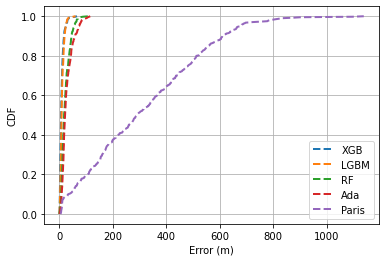

In [61]:
for d_reg, model in zip(dist_error_pr_reg, model_ls):
    cdf_plot(d_reg, label=model)

cdf_plot(pr_toa_e, label='Paris')

plt.legend(loc='best')
plt.grid()
# plt.title('Transfer learning with different regressors')
plt.ylabel('CDF')
plt.xlabel('Error (m)')
# plt.savefig('../imgs/tl_reg_comp_pr.pdf')

## regressor on Toulouse

In [99]:
pipes = [xgb_pipe, lgb_pipe, rf_pipe, ada_pipe]
model_ls = ['XGB', 'LGBM', 'RF', 'Ada']

In [101]:
dist_error_tl_reg = []

for pipe in pipes:
    pipe.fit(X_ld, dist_ld)
    dist_pred_tmp = pipe.predict(X_tl)
    loc_pred_tmp = optimize(RX_all_toul, dist_pred_tmp)

    dist_error_tl_reg.append(dist_from_geo(loc_pred_tmp, Y_all_toul))

[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1


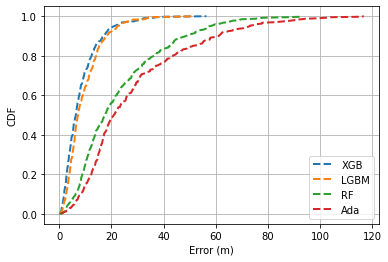

In [103]:
for d_reg, model in zip(dist_error_tl_reg, model_ls):
    cdf_plot(d_reg, label=model)

plt.legend(loc='best')
plt.grid()
# plt.title('Transfer learning with different regressors')
plt.ylabel('CDF')
plt.xlabel('Error (m)')
plt.savefig('../imgs/tl_reg_comp_tl8.pdf')

## Optimization

In [56]:
from scipy.optimize import minimize, Bounds

In [57]:
def dist2coord(x, coords, dists):

    d = np.array([geodesic(x, coord).m for coord in coords])

    return np.linalg.norm([d-dists])**2

def find_x(coords, dists):
    """find x through distance and rx coordinates"""
    x_pred = []

    bounds = Bounds([0, -90], [90, 90])

    for i, p in enumerate(dists):
        res = minimize(
        dist2coord,
        coords[0],
        args=(coords, p),
        method='L-BFGS-B',
        options={
            'ftol':1e-5,         # Tolerance
            'maxiter': 1e+7      # Maximum iterations
        },
        bounds=bounds
    )   

        x_pred.append(res.x)

    return np.array(x_pred)

In [86]:
loc_ld_pred = find_x(RX_all_ld, lgb_pipe.predict(x_test))

In [87]:
ld_dist_err = dist_from_geo(loc_ld_pred, tx_test)

In [88]:
loc_pr_pred = find_x(RX_all_pr, dist_pr_pred)

In [89]:
pr_dist_err = dist_from_geo(loc_pr_pred, Y_all_pr)

In [90]:
def cdf_plot(data, ax=plt, label=None):
    n = len(data)
    x = np.arange(n) / (n-1)
    y = np.sort(data)

    ax.plot(y, x, label=label, linewidth=2)

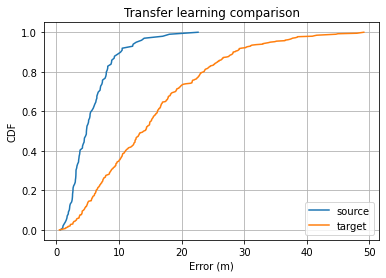

In [101]:
cdf_plot(ld_dist_err, label='source')
cdf_plot(pr_dist_err, label='target')
plt.title('Transfer learning comparison')
plt.ylabel('CDF')
plt.xlabel('Error (m)')
plt.legend(loc='best')
plt.grid()

# Algo comparison

In [97]:
pipes = [xgb_pipe, lgb_pipe, rf_pipe, ada_pipe]
model_ls = ['XGB', 'LGBM', 'RF', 'Ada']

In [98]:
pf_ld = PipesFitting(X_ld, Y_all_ld, RX_all_ld)
pf_ld.add_pipes(pipes, model_ls)
pf_ld.fit()

[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1


NameError: name 'dist_error_ld_reg' is not defined

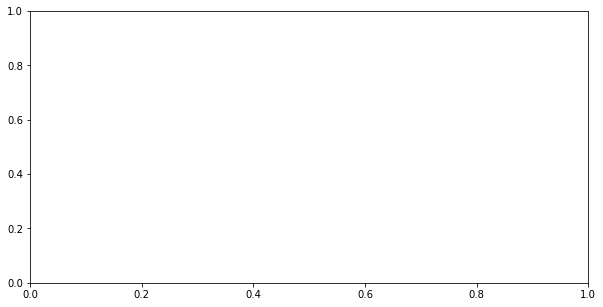

In [96]:
fig, ax = plt.subplots(figsize=(10,5))
dists_all = pf_ld.dist_all
for mode, dists, ld_dist in zip(model_ls, dists_all, dist_error_ld_reg):
    cdf_plot(dists, ax=ax, label=mode)
    cdf_plot(ld_dist, ax=ax, label=f'{mode} + Optimizer')


plt.legend()
plt.title('Localization in London city')
plt.ylabel('CDF')
plt.xlabel('Error (m)')

In [77]:
len(pf_ld.dist_all), len(pf_ld.dist_all[0])

(4, 100)

# Predict directly on position

In [98]:
x_train, x_test, y_train, y_test = train_test_split(X_ld, Y_all_ld, train_size=.75)


In [99]:
lgb_pipe.fit(x_train, y_train)
y_pred = lgb_pipe.predict(x_test)

[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1


In [100]:
lgb_pred_pr = lgb_pipe.predict(X_pr)
lgb_pred_tl = lgb_pipe.predict(X_tl)

In [101]:
pr_shift = Y_all_pr.mean(axis=0) - Y_all_ld.mean(axis=0)
tl_shift = Y_all_toul.mean(axis=0) - Y_all_ld.mean(axis=0)

In [102]:
pr_shift, tl_shift

(array([-2.68119791,  2.41160792]), array([-7.90599379,  1.53709086]))

In [103]:
dist_pr = dist_from_geo(lgb_pred_pr + pr_shift, Y_all_pr)
dist_tl = dist_from_geo(lgb_pred_tl + tl_shift, Y_all_toul)

In [104]:
def cdf_plot(data, ax=plt, label=None, c=None):
    n = len(data)
    x = np.arange(n) / (n-1)
    y = np.sort(data)

    ax.plot(y, x, '--',label=label, linewidth=2, color=c)

In [116]:
np.mean(pr_error), np.mean(toul_error), np.mean(dist_pr), np.mean(dist_tl)

(10.630328462548768, 13.82607462579812, 39.81637245513414, 59.548005284734955)

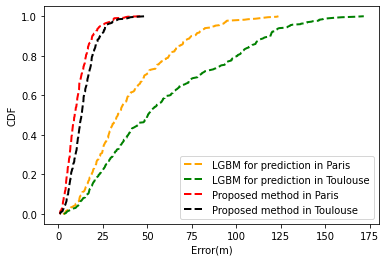

In [117]:
cdf_plot(dist_pr,label='LGBM for prediction in Paris', c='orange')
cdf_plot(dist_tl, label='LGBM for prediction in Toulouse', c='green')
cdf_plot(pr_error,label='Proposed method in Paris', c='r')
cdf_plot(toul_error,label='Proposed method in Toulouse', c='k')


plt.ylabel('CDF')
plt.xlabel('Error(m)')
plt.legend(loc='best')
# plt.savefig('../imgs/direct_compare.pdf')

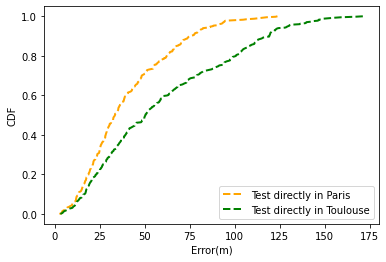

In [111]:
cdf_plot(dist_pr,label='Test directly in Paris', c='orange')
cdf_plot(dist_tl, label='Test directly in Toulouse', c='green')
plt.ylabel('CDF')
plt.xlabel('Error(m)')
plt.legend(loc='best')
plt.savefig('../imgs/direct.pdf')

NameError: name 'dist_tl' is not defined

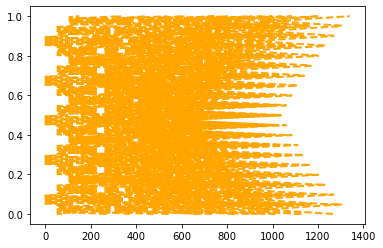

In [97]:
cdf_plot(dist_pr,label='Test directly in Paris', c='orange')
cdf_plot(dist_tl, label='Test directly in Toulouse', c='green')
plt.ylabel('CDF')
plt.xlabel('Error(m)')
plt.legend(loc='best')
# plt.savefig('../imgs/direct.pdf')

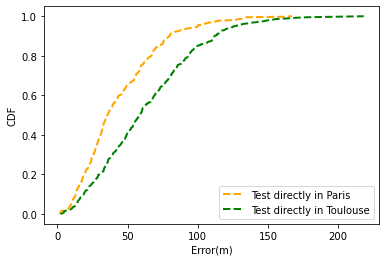

In [126]:
cdf_plot(dist_pr,label='Test directly in Paris', c='orange')
cdf_plot(dist_tl, label='Test directly in Toulouse', c='green')
plt.ylabel('CDF')
plt.xlabel('Error(m)')
plt.legend(loc='best')
# plt.savefig('../imgs/direct.pdf')

NameError: name 'dist_tl' is not defined

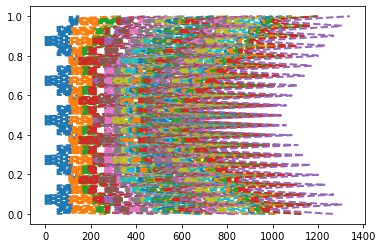

In [39]:
cdf_plot(dist_pr,label='Test directly in Paris')
cdf_plot(dist_tl, label='Test directly in Toulouse')
plt.ylabel('CDF')
plt.xlabel('Error(m)')
plt.legend(loc='best')
# plt.savefig('../imgs/direct.pdf')
